In [737]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pandas.api.types import CategoricalDtype

In [738]:
pd.options.display.max_columns = 195

In [739]:
df=pd.read_csv("data/Speed+Dating+Data.csv", encoding='ISO-8859-1')

# What's in the Dataset

- A very large dataset of 8378 rows and 195 columns
- Each row represents a speed date between a man and a woman during an event.
- Is called "partner" the person the participant meet during the speed date. <br>
**/!\ The dataset is not complete**. Indeed, some partners'id are not present in iid columns.<br>


- There were 21 events, called "waves," held between October 2002 and April 2004.
- During each wave, participants met between 5 and 22 different people ("rounds").

- A total of 551 unique individuals participated in at least one event. 
- At each event, the male-to-female ratio was almost always balanced: 277 men and 274 women.
- Men attendeed a total of 274 seeed dates.
- Women attendeed a total of 277 speed dates.
- If men liked 47.4% of their speed dates and women 36.5%, 16.4% of them resulted in a match.<br><br>





In [697]:
df.shape

(8378, 195)

In [698]:
df_women=df[df["gender"]==0]
df_men=df[df["gender"]==1]
print("Total number of women's iid :",df_women.shape[0])
print("Total number of men's iid  :",df_men.shape[0])
print()
print("Number of women's partner'id not present in iid men :",df_women[~df_women["partner"].isin(df_men["iid"])].shape[0])
print("Number of men's partner'id not present in iid women :",df_men[~df_men["partner"].isin(df_women["iid"])].shape[0])



Total number of women's iid : 4184
Total number of men's iid  : 4194

Number of women's partner'id not present in iid men : 2707
Number of men's partner'id not present in iid women : 1511


In [699]:
rounds_per_wave = df.groupby("wave")["round"].mean().reset_index()

fig = px.bar(
    rounds_per_wave,
    x="wave",
    y="round",
    labels={"wave": "Waves", "round": "Number of rounds"},
    title="Number of rounds per wave",
    hover_data={"wave": True, "round": True}
)

fig.show()

In [700]:
df_unique= df.drop_duplicates(subset='iid').copy()
print(f'Number of unique participants : {df_unique.shape[0]}')

Number of unique participants : 551


In [701]:
# A balanced male-to-female ratio. male=1, female=0
df_unique["gender"].value_counts()

gender
1    277
0    274
Name: count, dtype: int64

In [702]:
gender_counts = df_unique.groupby(["wave", "gender"]).size().unstack(fill_value=0).reset_index()
gender_counts.columns = ['wave', 'Women', 'Men']

fig = px.bar(
    gender_counts,
    x="wave",
    y=["Women", "Men"],
    labels={"wave": "Wave", "value": "Number of participants", "variable": "Gender"},
    title="Number of participants per wave and per gender <br><sub>Base: 274 women, 277 men.",
    barmode='group',
    color_discrete_map={'Women': 'red', 'Men': 'blue'}
)

fig.update_layout(
    xaxis_title='Waves',
    yaxis_title='Number of participants',
    legend_title='Gender'
)

fig.show()


In [703]:
pivot_df = df_unique.pivot_table(index='wave', columns='gender', values='round', aggfunc='count', fill_value=0)

pivot_df.columns = ['Number of round for Men', 'Number of round for Women']

print("Total number of round for women",pivot_df['Number of round for Women'].sum())
print("Total number of round for men",pivot_df['Number of round for Men'].sum())


Total number of round for women 277
Total number of round for men 274


In [704]:
# Map decision values
decision_mapping = {1: 'Yes', 0: 'No'}
df['decision_label'] = df['dec'].map(decision_mapping)

# Gender mapping
gender_mapping = {0: 'Women', 1: 'Men'}
df['gender_label'] = df['gender'].map(gender_mapping)

# Separate by gender (replace with your actual gender column and values)
df_men = df[df['gender_label'] == 'Men']
df_women = df[df['gender_label'] == 'Women']

# Count decisions for men
men_counts = df_men['decision_label'].value_counts().reset_index()
men_counts.columns = ['Decision', 'Count']

# Count decisions for women
women_counts = df_women['decision_label'].value_counts().reset_index()
women_counts.columns = ['Decision', 'Count']

# Create subplot layout
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type':'domain'}, {'type':'domain'}]],
    subplot_titles=['Women Decisions', 'Men Decisions']
)

# Add pie for women
fig.add_trace(go.Pie(
    labels=women_counts['Decision'],
    values=women_counts['Count'],
    name="Women",
    marker=dict(colors=['lightgrey', 'red']),
    textinfo='percent+label'
), row=1, col=1)

# Add pie for men
fig.add_trace(go.Pie(
    labels=men_counts['Decision'],
    values=men_counts['Count'],
    name="Men",
    marker=dict(colors=['lightgrey', 'blue']),
    textinfo='percent+label'
), row=1, col=2)



# Update layout
fig.update_layout(
    title_text='Decisions after a speed date<br><sub>Base: 274 women, 277 men.',
    showlegend=False,
    height=500,
    width=800
)

fig.show()


In [705]:
# Map match values to alphabetic values
match_mapping = {1: 'Match', 0: 'No Match'}
df['match_label'] = df['match'].map(match_mapping)

# Calculate the counts of each match type
match_counts = df["match_label"].value_counts().reset_index()
match_counts.columns = ['Match Type', 'Count']

# Calculate the total count
total_count = match_counts['Count'].sum()

# Calculate the percentages
match_counts['Percentage'] = (match_counts['Count'] / total_count) * 100

# Create a pie chart
fig = px.pie(
    match_counts,
    values='Count',
    names='Match Type',
    title='Match Distribution <br><sub>Base: 551 participants. 277 speed dates.',
    hover_data={'Percentage': True},
    labels={'Percentage': 'Percentage'},
)

# Update layout for better readability and adjust size
fig.update_traces(
    textposition='inside',
    textinfo='percent+label',
    marker=dict(colors=['lightgrey', 'green'])
)
fig.update_layout(
    width=600,  
    height=400  
)

# Show the plot
fig.show()


## Missing values analysis

In [706]:
columns_with_na = df.columns[(df.isna().sum() / len(df)).round(3) != 0]
print(f"{df[columns_with_na].shape[1]} columns with missing values, {((df[columns_with_na].shape[1])/len(df.columns))*100:.2f}% of the total number of columns")


181 columns with missing values, 91.41% of the total number of columns


In [707]:
# Filter the dataset on columns without NAN
percentage_na = (df.isna().sum() / len(df)).round(3)
columns_without_na = percentage_na[percentage_na == 0]

result_df_without_NA = pd.DataFrame({
    'Column Name': columns_without_na.index,
    'NA Rate': columns_without_na.values
})

print("columns without NAN:")
print(result_df_without_NA)

columns without NAN:
       Column Name  NA Rate
0              iid      0.0
1               id      0.0
2           gender      0.0
3              idg      0.0
4           condtn      0.0
5             wave      0.0
6            round      0.0
7         position      0.0
8            order      0.0
9          partner      0.0
10           match      0.0
11        samerace      0.0
12           dec_o      0.0
13             dec      0.0
14  decision_label      0.0
15    gender_label      0.0
16     match_label      0.0


The columns without missing values almost exclusively correspond to information **essential** for the speed dating event:

- Participant identifiers (IDs, gender, partner ID, whether the partners are from the same race)
- Information about the event (wave, number of rounds, participant's position, order of appearance, whether participants will meet more or fewer than 10 potential partners during the evening)
- Information about the outcome of the date (match, participant’s decision, partner’s decision)

In [708]:
# Filter the dataset on columns with NAN
percentage_na = (df.isna().sum() / len(df)).round(3)
columns_with_na = percentage_na[percentage_na != 0]

result_df_with_NA = pd.DataFrame({
    'Column Name': columns_with_na.index,
    'NA Rate': columns_with_na.values
})

# Order the DataFrame by 'NA Rate'
result_df_with_NA_sorted = result_df_with_NA.sort_values(by='NA Rate', ascending=False)

print("Columns with NAN (ordered by NAN rate) :")
print(result_df_with_NA_sorted)

Columns with NAN (ordered by NAN rate) :
    Column Name  NA Rate
146    num_in_3    0.920
145    numdat_3    0.821
55       expnum    0.785
112      amb7_2    0.767
109     sinc7_2    0.767
..          ...      ...
38     tvsports    0.009
37       sports    0.009
21        field    0.008
26         race    0.008
1           pid    0.001

[181 rows x 2 columns]


Although many columns contain missing values, those least frequently completed correspond to:

- **the potential follow-up of the dates** (whether additional meetings occurred after the event, and who initiated contact),
- **the participant’s self-assessed desirability** (how many people expressed interest in their profile),
- **the follow-up evaluations** conducted one day (Time2) or three to four weeks (Time3) after the event, regarding the partners they met, themselves, or characteristics perceived as important by the opposite gender,
- **academic performance, education level, and income.**

# Participant's profiles analysis

- Participants attending are, on average, 26 to 27 years old, with a similar distribution between men and women.
- There is a similar distribution in terms of race/ethnic background, with slightly more European/Caucasian-Americans among men.
- A large number of men work in business/economy/finance (followed by engineering, law, or biological sciences/chemistry/physics).
- Women, on the other hand, more often work in social sciences/psychology, education, or social work—fields where men are less present.

- Men and women attending the event go out with the same frequency—at least twice a week. However, women tend to go on dates slightly less often.
- Most participants of both sexes go on a date at least once a month.


In [709]:
print("average age Men: ",df_unique[df_unique["gender"]==1]["age"].mean().round(0))
print("average age women: ",df_unique[df_unique["gender"]==0]["age"].mean().round(0))
print("average age total:",df_unique["age"].mean().round(0))

average age Men:  27.0
average age women:  26.0
average age total: 26.0


In [755]:
# Gender mapping
gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Initialize the figure
fig = go.Figure()

# Add traces for Women
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Women']['age'],
        name='Women',
        marker_color='red',
        boxmean='sd',

    ),
)

# Add traces for Men
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Men']['age'],
        name='Men',
        marker_color='blue',
        boxmean='sd',
    ),
)

# Update layout with correct Y axis scale
fig.update_layout(
    title_text="Age of participants <br><sub>Base: 274 women, 277 men.",
    height=600,
    width=800,
)

fig.show()


In [711]:
# Mapping for race and gender
race_mapping = {
    1: 'Black/African American',
    2: 'European/Caucasian-American',
    3: "Latino/Hispanic American",
    4: "Asian/Pacific Islander/Asian-American",
    5: 'Native American',
    6: 'Other'
}
df_unique["Participant's_race"] = df_unique['race'].map(race_mapping)

gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Grouping by race and gender
race_gender_counts = df_unique.groupby(['Participant\'s_race', 'gender_label']).size().reset_index(name='count')

# Calculating percentages
total_men = len(df_unique[df_unique['gender_label'] == 'Men'])
total_women = len(df_unique[df_unique['gender_label'] == 'Women'])

race_gender_counts['percentage'] = race_gender_counts.apply(
    lambda row: f"{row['count'] / total_men * 100:.0f}%" if row['gender_label'] == 'Men'
    else f"{row['count'] / total_women * 100:.0f}%",
    axis=1
)

# Sort the data by total number of participants (men + women)
race_gender_counts_total = race_gender_counts.groupby('Participant\'s_race')['count'].sum().reset_index()
race_gender_counts_total = race_gender_counts_total.sort_values('count', ascending=False)

# Reorder data for men and women by the sorted race order
race_gender_counts = race_gender_counts.set_index('Participant\'s_race').loc[race_gender_counts_total['Participant\'s_race']].reset_index()

# Create the plot
fig = go.Figure(data=[
    go.Bar(name='Women', x=race_gender_counts[race_gender_counts['gender_label'] == 'Women']['Participant\'s_race'],
           y=race_gender_counts[race_gender_counts['gender_label'] == 'Women']['count'],
           text=race_gender_counts[race_gender_counts['gender_label'] == 'Women']['percentage'],
           textposition='outside', marker_color='red'),
    go.Bar(name='Men', x=race_gender_counts[race_gender_counts['gender_label'] == 'Men']['Participant\'s_race'],
           y=race_gender_counts[race_gender_counts['gender_label'] == 'Men']['count'],
           text=race_gender_counts[race_gender_counts['gender_label'] == 'Men']['percentage'],
           textposition='outside', marker_color='blue')
])

# Update layout
fig.update_layout(
    barmode='group',
    title='Distribution of race per gender <br><sub>Base: 274 women, 277 men.',
    xaxis_title='Race',
    yaxis_title='Number of participants',
    width=900,
    height=600
)

# Show the plot
fig.show()


In [712]:
field_mapping = {
    1: 'Law',
    2: 'Math',
    3: "Social Science, Psychologist",
    4: "Medical Science, Pharmaceuticals, and Bio Tech",
    5: 'Engineering',
    6: 'English/Creative Writing/ Journalism',
    7: 'History/Religion/Philosophy',
    8: 'Business/Econ/Finance',
    9: 'Education, Academia',
    10: 'Biological Sciences/Chemistry/Physics',
    11: 'Social Work',
    12: 'Undergrad/undecided',
    13: 'Political Science/International Affairs',
    14: 'Film',
    15: 'Fine Arts/Arts Administration',
    16: 'Languages',
    17: 'Architecture',
    18: 'Other'
}

df_unique["Participant's_field"] = df_unique['field_cd'].map(field_mapping)

field_counts = df_unique["Participant's_field"].value_counts().reset_index()
field_counts.columns = ["Participant's_field", "count"]

field_counts = field_counts.sort_values('count', ascending=False)

fig = go.Figure(data=[
    go.Bar(
        x=field_counts["Participant's_field"],
        y=field_counts["count"],
        text=field_counts["count"],
        textposition='outside',
        marker_color='mediumpurple'
    )
])

fig.update_layout(
    title="Participants' field distribution <br><sub>Base: 551 participants.",
    xaxis_title="Field",
    yaxis_title="Number of participants",
    width=900,
    height=600
)

fig.show()


In [713]:
gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Compute counts for each combination of field and gender
field_gender_counts = df_unique.groupby(["Participant's_field", 'gender_label']).size().reset_index(name='count')

# --- Sort fields by total participants (Men + Women) ---
field_total_counts = field_gender_counts.groupby("Participant's_field")['count'].sum().reset_index()
sorted_fields = field_total_counts.sort_values('count', ascending=False)["Participant's_field"].tolist()

# Create the figure
fig = go.Figure(data=[
    go.Bar(name='Women', 
           x=field_gender_counts[field_gender_counts['gender_label'] == 'Women']["Participant's_field"],
           y=field_gender_counts[field_gender_counts['gender_label'] == 'Women']['count'],
           text=field_gender_counts[field_gender_counts['gender_label'] == 'Women']['count'],  
           textposition='outside', marker_color='red'),
    
    go.Bar(name='Men', 
           x=field_gender_counts[field_gender_counts['gender_label'] == 'Men']["Participant's_field"],
           y=field_gender_counts[field_gender_counts['gender_label'] == 'Men']['count'],
           text=field_gender_counts[field_gender_counts['gender_label'] == 'Men']['count'],  
           textposition='outside', marker_color='blue')
])

# Update layout to force the correct X-axis order
fig.update_layout(
    barmode='group',
    title="Participants' field distribution (ordered by total number of participants per field) <br><sub>Base: 274 women, 277 men.",
    yaxis_title='Number of participants',
    xaxis=dict(
        categoryorder='array',
        categoryarray=sorted_fields
    ),
    width=900, 
    height=600  
)

fig.show()



In [714]:
print("Mean frequency of date :") 
print('Men :', df_unique[df_unique['gender']==1]["date"].mean())
print('Women :', df_unique[df_unique['gender']==0]["date"].mean())
print()
print('Median frequency of date :') 
print('Men :', df_unique[df_unique['gender']==1]["date"].median())
print('Women :', df_unique[df_unique['gender']==0]["date"].median())

Mean frequency of date :
Men : 4.835766423357664
Women : 5.133828996282528

Median frequency of date :
Men : 5.0
Women : 5.0


In [715]:
date_mapping = {
    1: "Several times a week",
    2: "Twice a week",
	3: "Once a week",
	4: "Twice a month",
	5: "Once a month",
	6: "Several times a year",
	7: "Almost never"

}
df_unique["date_label"] = df_unique['date'].map(date_mapping)

gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

date_gender_counts = df_unique.groupby(['date_label', 'gender_label']).size().reset_index(name='count')

total_men = len(df_unique[df_unique['gender_label'] == 'Men'])
total_women = len(df_unique[df_unique['gender_label'] == 'Women'])

date_gender_counts['percentage'] = date_gender_counts.apply(
    lambda row: f"{row['count'] / total_men * 100:.0f}%" if row['gender_label'] == 'Men'
    else f"{row['count'] / total_women * 100:.0f}%",
    axis=1
)


# Initialize the figure
fig = go.Figure()
# Create the plot
fig = go.Figure(data=[
    go.Bar(
        name='Women', 
        x=date_gender_counts[date_gender_counts['gender_label'] == 'Women']['date_label'],
        y=date_gender_counts[date_gender_counts['gender_label'] == 'Women']['count'],
        text=date_gender_counts[date_gender_counts['gender_label'] == 'Women']['percentage'],
        textposition='outside', 
        marker_color='red'
    ),
    go.Bar(
        name='Men', 
        x=date_gender_counts[date_gender_counts['gender_label'] == 'Men']['date_label'],
        y=date_gender_counts[date_gender_counts['gender_label'] == 'Men']['count'],
        text=date_gender_counts[date_gender_counts['gender_label'] == 'Men']['percentage'],
        textposition='outside', 
        marker_color='blue'
    )
])

# Update layout to keep the order of the dates
fig.update_layout(
    barmode='group',
    title='Frequency of date per gender <br><sub>Base: 274 women, 277 men.',
    xaxis_title='Frequency of date',
    yaxis_title='Number of participants',
    xaxis=dict(
        categoryorder='array',
        categoryarray=["Several times a week", "Twice a week", "Once a week", 
                       "Twice a month", "Once a month", "Several times a year", "Almost never"]
    ),
    width=900, 
    height=600  
)


fig.show()

In [716]:
print("Mean frequency of going out :") 
print('Men :', df_unique[df_unique['gender']==1]["go_out"].mean())
print('Women :', df_unique[df_unique['gender']==0]["go_out"].mean())
print()
print('Median frequency of going out :') 
print('Men :', df_unique[df_unique['gender']==1]["go_out"].median())
print('Women :', df_unique[df_unique['gender']==0]["go_out"].median())


Mean frequency of going out :
Men : 2.1563636363636363
Women : 2.130111524163569

Median frequency of going out :
Men : 2.0
Women : 2.0


In [717]:
go_out_mapping = {
    1: "Several times a week",
    2: "Twice a week",
	3: "Once a week",
	4: "Twice a month",
	5: "Once a month",
	6: "Several times a year",
	7: "Almost never"

}
df_unique["go_out_label"] = df_unique['go_out'].map(go_out_mapping)

gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

go_out_gender_counts = df_unique.groupby(['go_out_label', 'gender_label']).size().reset_index(name='count')

total_men = len(df_unique[df_unique['gender_label'] == 'Men'])
total_women = len(df_unique[df_unique['gender_label'] == 'Women'])

go_out_gender_counts['percentage'] = go_out_gender_counts.apply(
    lambda row: f"{row['count'] / total_men * 100:.0f}%" if row['gender_label'] == 'Men'
    else f"{row['count'] / total_women * 100:.0f}%",
    axis=1
)


# Initialize the figure
fig = go.Figure()
# Create the plot
fig = go.Figure(data=[
    go.Bar(
        name='Women', 
        x=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Women']['go_out_label'],
        y=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Women']['count'],
        text=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Women']['percentage'],
        textposition='outside', 
        marker_color='red'
    ),
    go.Bar(
        name='Men', 
        x=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Men']['go_out_label'],
        y=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Men']['count'],
        text=go_out_gender_counts[go_out_gender_counts['gender_label'] == 'Men']['percentage'],
        textposition='outside', 
        marker_color='blue'
    )
])

# Update layout to keep the order
fig.update_layout(
    barmode='group',
    title='Frequency of going out per gender<br><sub>Base: 274 women, 277 men.',
    xaxis_title='Frequency of going out',
    yaxis_title='Number of participants',
    xaxis=dict(
        categoryorder='array',
        categoryarray=["Several times a week", "Twice a week", "Once a week", 
                       "Twice a month", "Once a month", "Several times a year", "Almost never"]
    ),
    width=900, 
    height=600  
)


fig.show()

## Attributes evaluation of themself

### Check of the answers accuracy :

Scales of attributes' evaluation have changed depending on the waves. In top of that, it seams that some questions have not been answered correctly by attendees (answers given out of range). Since it's not possible to analyse the answers of all participants together, some questions have been filtered.

In [718]:
df_unique_waves_69 = df_unique[(df_unique["wave"]>=6) & (df_unique["wave"]<=9)]
df_unique_waves_other = df_unique.drop(df_unique_waves_69.index)
df_unique_waves_1021 = df_unique[(df_unique["wave"]>=10) & (df_unique["wave"]<=21)]

In [719]:
# Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):
# It looks like the question has not been answered correctly by the attendees in waves 6 to 9 since max values are out of range (1 to 10)
# For this reason, we will only consider waves 1 to 5 and 10 to 21 for this question
attributes = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
df_max_values = df_unique_waves_69[attributes + ['wave']].groupby('wave').max()
df_max_values

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1
wave,,,,,,
6,20.83,22.73,20.00,20.83,20.00,19.57
7,27.78,23.08,22.73,27.78,19.57,19.57
8,20.93,23.81,23.26,22.50,20.41,17.39
9,25.64,23.81,23.81,23.81,20.59,23.81


In [720]:
# Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.
# the attributes' rating seams globally correct
attributes = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
df_mean_values = df_unique_waves_other[attributes + ['wave']].groupby('wave').mean()
df_mean_values["total"] =  df_mean_values[attributes].sum(axis=1)
df_mean_values

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,total
wave,,,,,,,
1,32.321000,11.114500,19.869000,19.614500,7.414500,9.665500,99.999000
2,24.088235,18.029412,23.352941,16.558824,9.352941,9.205882,100.588235
3,22.555556,15.666667,21.444444,18.722222,11.666667,12.111111,102.166667
4,19.750000,18.000000,22.083333,16.611111,10.416667,12.861111,99.722222
5,30.789474,15.526316,18.421053,19.166667,10.882353,8.235294,103.021156
10,22.444444,19.333333,18.666667,16.166667,10.333333,13.055556,100.000000
11,22.135000,19.254048,21.158810,16.754048,9.611190,11.087381,100.000476
12,21.523929,19.894643,21.066429,15.447143,10.117500,11.950714,100.000357
13,22.117647,17.411765,18.470588,17.117647,12.411765,12.470588,100.000000


### Analysis

Participants, both men and women, seem to have a generally good perception of themselves and believe that others have a generally good perception of them as well. There are no differences between men and women in this regard.

In [721]:
# Attributes own perception
attributes1 = ['attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1', 'amb3_1']
men_means1 = df_unique[df_unique['gender'] == 1][attributes1].mean()
women_means1 = df_unique[df_unique['gender'] == 0][attributes1].mean()

# Attributes other perception's of them
attributes2 = ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']
men_means2 = df_unique[df_unique['gender'] == 1][attributes2].mean()
women_means2 = df_unique[df_unique['gender'] == 0][attributes2].mean()

# Create figure with 1 row, 2 columns
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Perception of Self', 'Perception of Self by Others'],
    specs=[[{'type': 'polar'}, {'type': 'polar'}]]
)

# Add first plot (Perception of Self)
fig.add_trace(go.Scatterpolar(
    r=women_means1.values.tolist() + [women_means1.values[0]],  
    theta=attributes1 + [attributes1[0]],  
    mode='lines+markers',
    name='Women',
    marker_color='red'
), row=1, col=1)

fig.add_trace(go.Scatterpolar(
    r=men_means1.values.tolist() + [men_means1.values[0]],  
    theta=attributes1 + [attributes1[0]],  
    mode='lines+markers',
    name='Men',
    marker_color='blue'
), row=1, col=1)

# Add second plot (Perception of Self by Others)
fig.add_trace(go.Scatterpolar(
    r=women_means2.values.tolist() + [women_means2.values[0]],  
    theta=attributes2 + [attributes2[0]],  
    mode='lines+markers',
    name='Women',
    marker_color='red',
    showlegend=False  
), row=1, col=2)

fig.add_trace(go.Scatterpolar(
    r=men_means2.values.tolist() + [men_means2.values[0]],  
    theta=attributes2 + [attributes2[0]],  
    mode='lines+markers',
    name='Men',
    marker_color='blue',
    showlegend=False 
), row=1, col=2)

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  
        )
    ),
    polar2=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  
        )
    ),
    showlegend=True,  
    title=f"Comparison of Perceptions (Self vs. Others)<br><sup>Base all waves: 274 women, 277 men. 1=awful, 10=great</sup>",
    width=850,
    height=600
)

fig.show()



# Expectations regarding the event

- For most participants of both genders, attending the event is an oportunity to spend a fun night out or to meet new people. Only a few (more often men) are hoping to get a date or find a serious relationship.
- Men are more often than women expectig "being happy with the people they meet during the event". 
- Women tend to be slightly more confident than men about how they could interest other participants during the event

In [722]:
goal_mapping = {
    1: "Seemed like a fun night out",
	2: "To meet new people",
	3: "To get a date",
	4: "Looking for a serious relationship",
	5: "To say I did it",
	6: "Other"
}
df_unique["goal_label"] = df_unique['goal'].map(goal_mapping)

gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

goal_gender_counts = df_unique.groupby(['goal_label', 'gender_label']).size().reset_index(name='count')

total_men = len(df_unique[df_unique['gender_label'] == 'Men'])
total_women = len(df_unique[df_unique['gender_label'] == 'Women'])

goal_gender_counts['percentage'] = goal_gender_counts.apply(
    lambda row: f"{row['count'] / total_men * 100:.0f}%" if row['gender_label'] == 'Men'
    else f"{row['count'] / total_women * 100:.0f}%",
    axis=1
)

# Sort the goals based on the total count (men + women)
goal_gender_counts_total = goal_gender_counts.groupby('goal_label')['count'].sum().reset_index()
goal_gender_counts_total = goal_gender_counts_total.sort_values('count', ascending=False)
# Merge the total count data back into the original DataFrame to retain the sorting order
goal_gender_counts = goal_gender_counts.set_index('goal_label').loc[goal_gender_counts_total['goal_label']].reset_index()

# Initialize the figure
fig = go.Figure()
# Create the plot
fig = go.Figure(data=[
    go.Bar(
        name='Women', 
        x=goal_gender_counts[goal_gender_counts['gender_label'] == 'Women']['goal_label'],
        y=goal_gender_counts[goal_gender_counts['gender_label'] == 'Women']['count'],
        text=goal_gender_counts[goal_gender_counts['gender_label'] == 'Women']['percentage'],
        textposition='outside', 
        marker_color='red'
    ),
    go.Bar(
        name='Men', 
        x=goal_gender_counts[goal_gender_counts['gender_label'] == 'Men']['goal_label'],
        y=goal_gender_counts[goal_gender_counts['gender_label'] == 'Men']['count'],
        text=goal_gender_counts[goal_gender_counts['gender_label'] == 'Men']['percentage'],
        textposition='outside', 
        marker_color='blue'
    )
])

# Update layout
fig.update_layout(
    barmode='group',
    title='Distribution of goal per gender. <br><sub>Base: 274 women, 277 men.',
    xaxis_title='Goals',
    yaxis_title='Number of participants',
    width=900, 
    height=600  
)

fig.show()

In [723]:
# Gender mapping
gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Initialize the figure
fig = go.Figure()

# Add traces for Women
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Women']['exphappy'],
        name='Women',
        marker_color='red',
    ),
)

# Add traces for Men
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Men']['exphappy'],
        name='Men',
        marker_color='blue',
    ),
)

# Update layout with correct Y axis scale
fig.update_layout(
    title_text="Expectation of being happy with the people met during the speed date event<br><sub>Base: 274 women, 277 men.",
    height=600,
    width=800,
    yaxis=dict(
        title='Expectation from 1 to 10',
        tickmode='linear',
        dtick=1,
        range=[0.5, 10.5]
))

fig.show()


In [724]:
# Gender mapping
gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Initialize the figure
fig = go.Figure()

# Add traces for Women
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Women']['expnum'],
        name='Women',
        marker_color='red',
    ),
)

# Add traces for Men
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Men']['expnum'],
        name='Men',
        marker_color='blue',
    ),
)

# Update layout with correct Y axis scale
fig.update_layout(
    title_text="Number of people the participant expect to be interested in dating them<br><sub>Base: 274 women, 277 men.",
    height=600,
    width=800,
    yaxis=dict(
        title='Expectation from 1 to 20',
        tickmode='linear',
        dtick=1,
        range=[-0.5, 20.5]
))

fig.show()


# Dating priorities


- For men, attractiveness is by far the most important attribute they are looking for.
- For women, the distribution is more balanced. Intelligence comes first, followed closely by attractiveness and fun.
- Participants' perceptions of what others of the same sex look for are quite different. Women believe that other women prioritize attractiveness first, with intelligence, ambition, and sincerity being less important.
- On the other hand, men believe that other men think like them, prioritizing attractiveness. However, they believe other men are also looking for an ambitious partner.
- Both genders agree that the opposite sex primarily looks for attractiveness, and their perceptions of the importance of other attributes are similar. The exception is ambition, where women believe this attribute is more important to men.


Finaly, dating in the same race or religious background is more important for women than for men.

In [725]:
# what you're looking for
attributes1 = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
men_means1 = df_unique_waves_other[df_unique_waves_other['gender'] == 1][attributes1].mean()
women_means1 = df_unique_waves_other[df_unique_waves_other['gender'] == 0][attributes1].mean()

# What opposite sex look for
attributes3 = ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
men_means3 = df_unique_waves_other[df_unique_waves_other['gender'] == 1][attributes3].mean()
women_means3 = df_unique_waves_other[df_unique_waves_other['gender'] == 0][attributes3].mean()

# What other fellows look for
attributes2 = ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']
men_means2 = df_unique_waves_1021[df_unique_waves_1021['gender'] == 1][attributes2].mean()
women_means2 = df_unique_waves_1021[df_unique_waves_1021['gender'] == 0][attributes2].mean()

# Calculate base counts
base_women_other = len(df_unique_waves_other[df_unique_waves_other['gender'] == 0])
base_men_other = len(df_unique_waves_other[df_unique_waves_other['gender'] == 1])
base_women_1021 = len(df_unique_waves_1021[df_unique_waves_1021['gender'] == 0])
base_men_1021 = len(df_unique_waves_1021[df_unique_waves_1021['gender'] == 1])

# Create figure with 1 row, 3 columns
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=['What participants look for', 'What they think fellow men/women look for', 'What they think opposite sex look for'],
    specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]]
)

# Add first plot 
fig.add_trace(go.Scatterpolar(
    r=women_means1.values.tolist() + [women_means1.values[0]],  
    theta=attributes1 + [attributes1[0]],  
    mode='lines+markers',  
    name='Women',
    marker_color='red'
), row=1, col=1)

fig.add_trace(go.Scatterpolar(
    r=men_means1.values.tolist() + [men_means1.values[0]],  
    theta=attributes1 + [attributes1[0]],  
    mode='lines+markers',  
    name='Men',
    marker_color='blue'
), row=1, col=1)

# Add second plot 
fig.add_trace(go.Scatterpolar(
    r=women_means3.values.tolist() + [women_means3.values[0]],  
    theta=attributes3 + [attributes3[0]],  
    mode='lines+markers',  
    name='Women',
    marker_color='red',
    showlegend=False  
), row=1, col=2)

fig.add_trace(go.Scatterpolar(
    r=men_means3.values.tolist() + [men_means3.values[0]],  
    theta=attributes3 + [attributes3[0]],  
    mode='lines+markers',  
    name='Men',
    marker_color='blue',
    showlegend=False 
), row=1, col=2)

# Add tird plot 
fig.add_trace(go.Scatterpolar(
    r=women_means2.values.tolist() + [women_means2.values[0]],  
    theta=attributes2 + [attributes2[0]],  
    mode='lines+markers',  
    name='Women',
    marker_color='red',
    showlegend=False  
), row=1, col=3)

fig.add_trace(go.Scatterpolar(
    r=men_means2.values.tolist() + [men_means2.values[0]],  
    theta=attributes2 + [attributes2[0]],  
    mode='lines+markers',  
    name='Men',
    marker_color='blue',
    showlegend=False 
), row=1, col=3)

# Add annotations for base counts at the bottom left
fig.add_annotation(
    text=f"Base Women waves 1-5 and 10-21: {base_women_other}",
    xref="paper", yref="paper",
    x=0.0, y=-0.12,  # Position at the bottom left
    showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.add_annotation(
    text=f"Base Men waves 1-5 and 10-21: {base_men_other}",
    xref="paper", yref="paper",
    x=0.0, y=-0.17,  # Position below the first annotation
    showarrow=False,
    font=dict(size=12),
    align="left"
)

# Add annotations for base counts at the bottom left
fig.add_annotation(
    text=f"Base Women waves 1-5 and 10-21: {base_women_other}",
    xref="paper", yref="paper",
    x=0.5, y=-0.12,  # Position at the bottom left
    showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.add_annotation(
    text=f"Base Men waves 1-5 and 10-21: {base_men_other}",
    xref="paper", yref="paper",
    x=0.5, y=-0.17,  # Position below the first annotation
    showarrow=False,
    font=dict(size=12),
    align="left"
)

# Add annotations for base counts at the bottom right
fig.add_annotation(
    text=f"Base Women waves 10-21: {base_women_1021}",
    xref="paper", yref="paper",
    x=1.0, y=-0.12,  # Position at the bottom right
    showarrow=False,
    font=dict(size=12),
    align="left"
)

fig.add_annotation(
    text=f"Base Men waves 10-21: {base_men_1021}",
    xref="paper", yref="paper",
    x=1.0, y=-0.17,  # Position below the first annotation
    showarrow=False,
    font=dict(size=12),
    align="left"
)


# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 40]  
        )
    ),
    polar2=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 40]  
        )
    ),
    polar3=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 40]  
        )
    ),
    showlegend=True,  # This ensures the legend will only be shown once
    title="Comparison of Perceptions<br><sup> 1=awful, 100=great. Total must equal 100</sup>",
    width=1450,
    height=500
)

fig.show()

In [726]:
# Gender mapping
gender_mapping = {0: 'Women', 1: 'Men'}
df_unique['gender_label'] = df_unique['gender'].map(gender_mapping)

# Create subplots
fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=(
        "Dating someone of same race/ethnic background", 
        "Dating someone of same religious background"
    )
)

# Add first boxplot: Importance of race
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Women']['imprace'],
        name='Women',
        marker_color='red',
        boxmean='sd'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Men']['imprace'],
        name='Men',
        marker_color='blue',
        boxmean='sd'
    ),
    row=1, col=1
)


# Add second boxplot: Importance of religion
fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Women']['imprelig'],
        name='Women',
        marker_color='red',
        boxmean='sd',
        showlegend=False  # Hide duplicate legend
    ),
    row=1, col=2
)

fig.add_trace(
    go.Box(
        y=df_unique[df_unique['gender_label'] == 'Men']['imprelig'],
        name='Men',
        marker_color='blue',
        boxmean='sd',
        showlegend=False
    ),
    row=1, col=2
)

# Update layout with correct Y axis scale
fig.update_layout(
    title_text="Importance of dating someone of same race/ethnic or same religious background<br><sub>Base: 274 women, 277 men.",
    height=500,
    width=1000,
    yaxis=dict(
        title='Importance',
        tickmode='linear',
        dtick=1,
        range=[-0.5, 10.5]   
    ),
    yaxis2=dict(
        title='Importance',
        tickmode='linear',
        dtick=1,
        range=[-0.5, 10.5]  
    ),
)

fig.show()


# What makes a match:

## Hypothesis 1 : More choice leads to a higher chance of matching.

**Hypothesis Rejected :** The amount of rounds -people met during the night- doens't influence much the possibility of a match. Indeed, if the night with the higher match rate has only 10 rounds, others nights with 10 rounds didn't show similar results.

In [727]:
# Group and compute means
match_per_wave = df.groupby("wave")[["match", "round"]].mean().reset_index()
match_per_wave["match_percent"] = (match_per_wave["match"] * 100).round(0)

# Define round categories and order
round_order = ["≤6", "7–8", "9–10", "11–12", "13–14", "15–16", "17–18", "19–22"]
cat_type = CategoricalDtype(categories=round_order, ordered=True)

# Categorize round values
match_per_wave["round_group"] = pd.cut(
    match_per_wave["round"],
    bins=[0, 6, 8, 10, 12, 14, 16, 18, 22],
    labels=round_order,
    include_lowest=True
).astype(cat_type)

# Define yellow-to-purple color gradient
yellow_purple_gradient = {
    "≤6": "#FFFFB2",
    "7–8": "#FED976",
    "9–10": "#FEB24C",
    "11–12": "#FD8D3C",
    "13–14": "#FC4E2A",
    "15–16": "#E31A1C",
    "17–18": "#BD0026",
    "19–22": "#800026"
}

# Sort by match percent
match_per_wave = match_per_wave.sort_values("match_percent", ascending=False)

# Convert wave to string and preserve order
match_per_wave["wave_str"] = match_per_wave["wave"].astype(str)
wave_order = match_per_wave["wave_str"].tolist()

# Create the plot
fig = px.bar(
    match_per_wave,
    x="wave_str",
    y="match_percent",
    color="round_group",
    color_discrete_map=yellow_purple_gradient,
    category_orders={
        "wave_str": wave_order,
        "round_group": round_order
        },
    labels={
        "wave_str": "Waves",
        "match_percent": "Percentage of match (%)",
        "round_group": "Number of people met during the event"
    },
    title="Percentage of match per wave (Ordered by match rate)<br><sub>Base: 551 participants. 277 speed dates.",
    hover_data={"wave_str": True, "match_percent": True, "round": True}
)

fig.show()

## Hypothesis 2 : Those who consider race important tend to like people of the same race.

**Hypothesis Rejected :** People for who dating in the same race was important like as much people of same race than people of different race.

In [728]:
df[(df["imprace"]==5) & (df["dec"]==1)]["samerace"].value_counts()/len(df[(df["imprace"]==5) & (df["dec"]==1)])*100

samerace
0    52.03252
1    47.96748
Name: count, dtype: float64

## Hypothesis 3: People are more likely to match with partners who have similar ratings of interests.

**Hypothesis rejected:** People are not significantly matching with partners with higher correlation rate

In [729]:
# match mapping
match_mapping = {0: 'No match', 1: 'Match'}
df['match_label'] = df['match'].map(match_mapping)

# Initialize the figure
fig = go.Figure()

# Add traces for no match
fig.add_trace(
    go.Box(
        y=df[df['match_label'] == 'No match']['int_corr'],
        name='No match',
        marker_color='grey',
        boxmean='sd',
    ),
)

# Add traces for match
fig.add_trace(
    go.Box(
        y=df[df['match_label'] == 'Match']['int_corr'],
        name='Match',
        marker_color='green',
        boxmean='sd',

    ),
)

# Update layout with correct Y axis scale
fig.update_layout(
    title_text="Correlation between participant’s and partner’s ratings of interest <br><sub>Base: 277 speed dates",
    yaxis_title='Correlation',
    height=600,
    width=800,
)

fig.show()


## Hypothesis 4 : Some fields of activity have higher match rates than others.

Since the dataset is not complete, we can't have a full analysis of matching fields. However, we can assume that women working in political sciences or law fields mostly matched with men working in law and business/economy/finance fields (2 fields more represented among men participants).

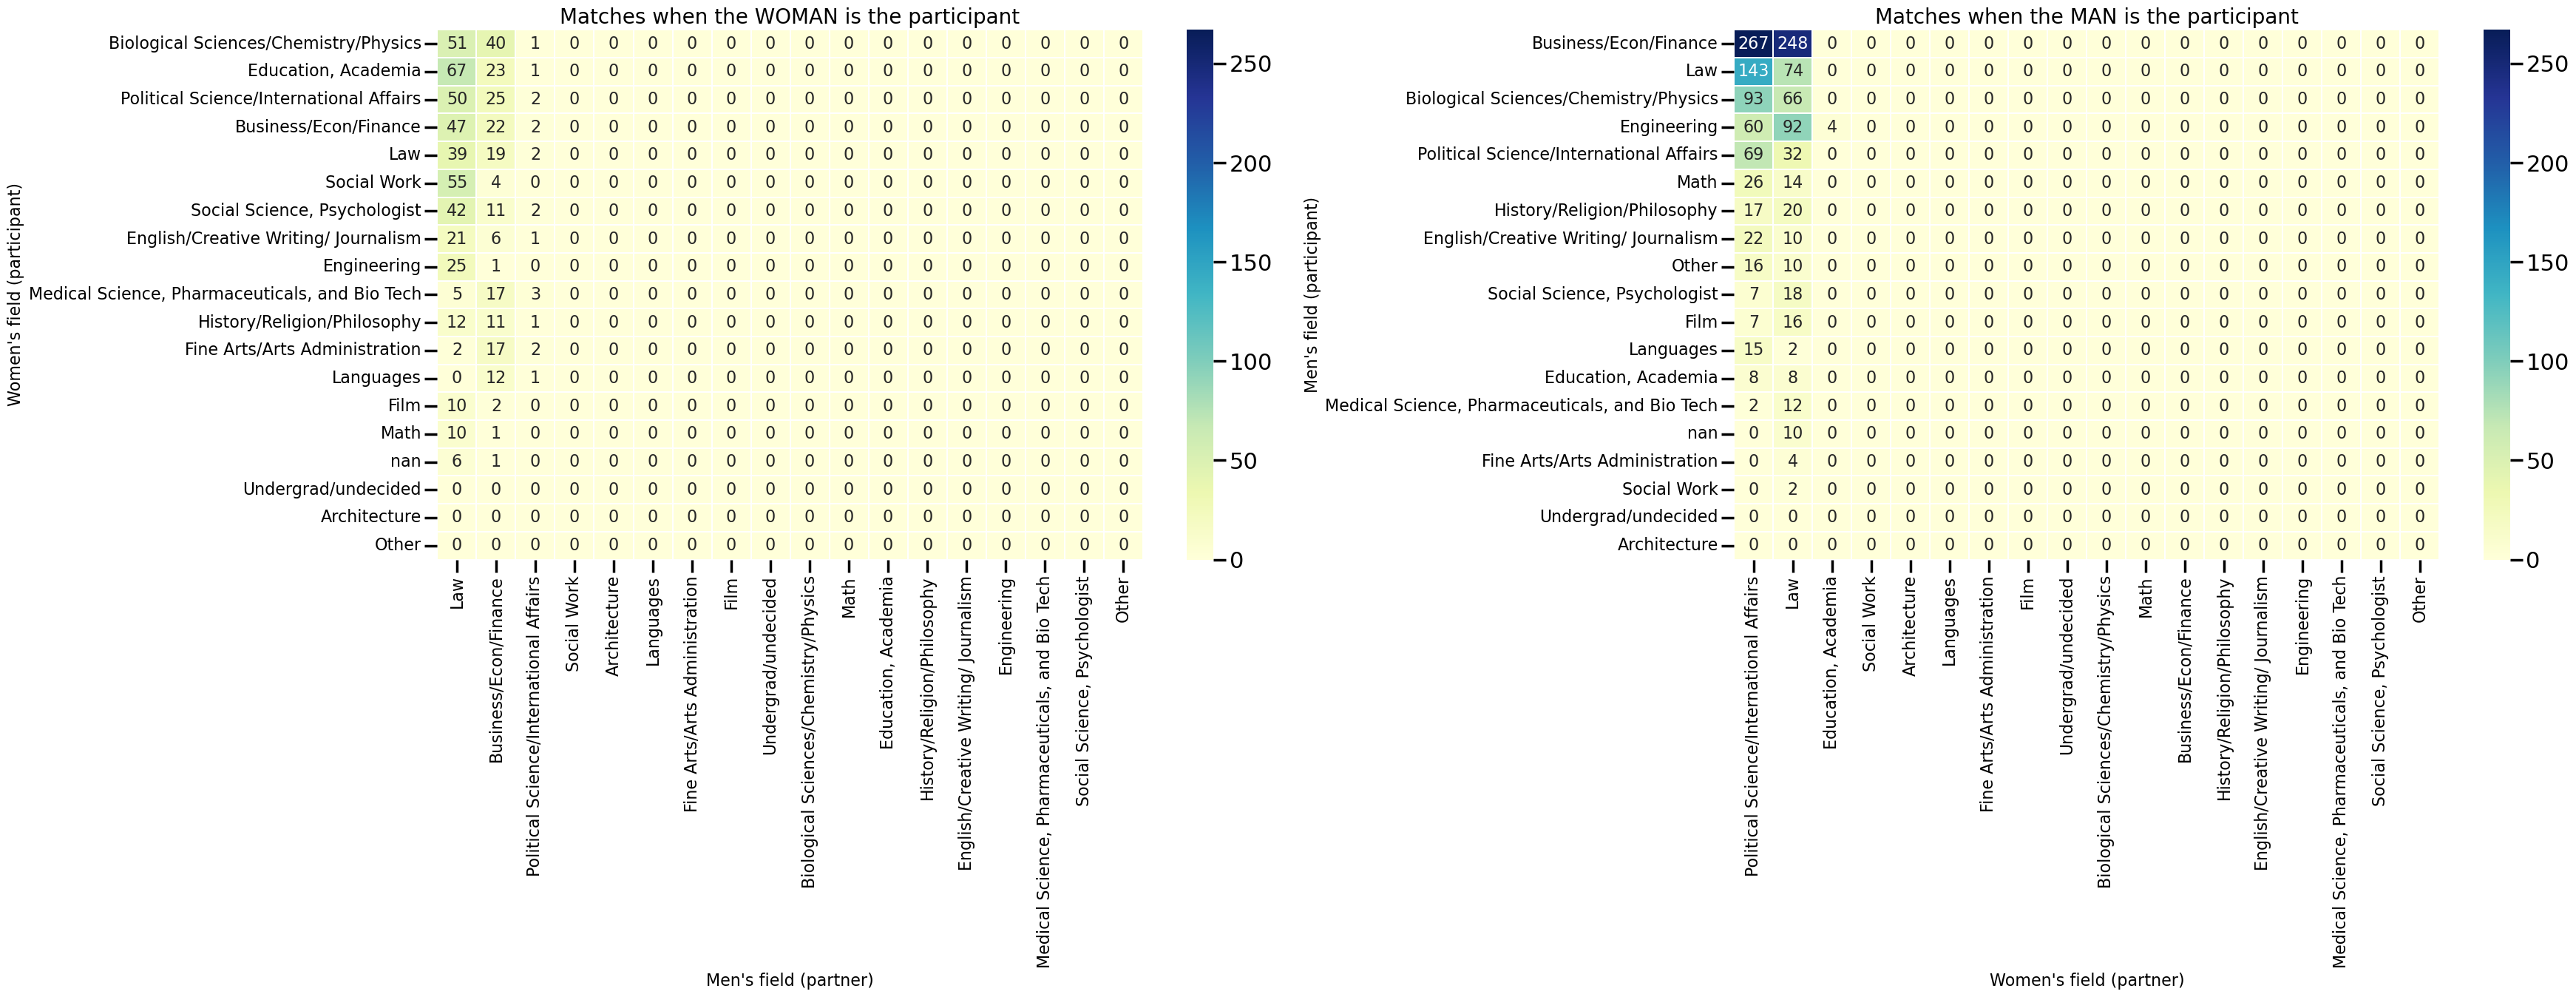

In [730]:
# 1. Map field codes to labels
field_mapping = {
    1: 'Law',
    2: 'Math',
    3: "Social Science, Psychologist",
    4: "Medical Science, Pharmaceuticals, and Bio Tech",
    5: 'Engineering',
    6: 'English/Creative Writing/ Journalism',
    7: 'History/Religion/Philosophy',
    8: 'Business/Econ/Finance',
    9: 'Education, Academia',
    10: 'Biological Sciences/Chemistry/Physics',
    11: 'Social Work',
    12: 'Undergrad/undecided',
    13: 'Political Science/International Affairs',
    14: 'Film',
    15: 'Fine Arts/Arts Administration',
    16: 'Languages',
    17: 'Architecture',
    18: 'Other'
}
df["field_label"] = df['field_cd'].map(field_mapping)

# 2. Define consistent field order and type
field_order = list(field_mapping.values())
cat_type = CategoricalDtype(categories=field_order, ordered=True)

# 3. Filter and merge data when the woman is the participant
df_match_women = df[(df["match"] == 1) & (df["gender"] == 0)]
df_match_men = df[(df["match"] == 1) & (df["gender"] == 1)]

merged_df_women = df_match_women.merge(
    df_match_men[['iid', 'field_label']],
    left_on='partner',
    right_on='iid',
    suffixes=('_participant', '_partner')
)
merged_df_women['field_label_participant'] = merged_df_women['field_label_participant'].astype(cat_type)
merged_df_women['field_label_partner'] = merged_df_women['field_label_partner'].astype(cat_type)

table_women = pd.crosstab(
    merged_df_women['field_label_participant'],
    merged_df_women['field_label_partner'],
    dropna=False
)

# 4. Filter and merge data when the man is the participant
merged_df_men = df_match_men.merge(
    df_match_women[['iid', 'field_label']],
    left_on='partner',
    right_on='iid',
    suffixes=('_participant', '_partner')
)
merged_df_men['field_label_participant'] = merged_df_men['field_label_participant'].astype(cat_type)
merged_df_men['field_label_partner'] = merged_df_men['field_label_partner'].astype(cat_type)

table_men = pd.crosstab(
    merged_df_men['field_label_participant'],
    merged_df_men['field_label_partner'],
    dropna=False
)

# Sort to place higher counts at the top-left
table_women = table_women.loc[
    table_women.sum(axis=1).sort_values(ascending=False).index,
    table_women.sum(axis=0).sort_values(ascending=False).index
]

table_men = table_men.loc[
    table_men.sum(axis=1).sort_values(ascending=False).index,
    table_men.sum(axis=0).sort_values(ascending=False).index
]

# 5. Set common color scale
vmax = max(table_women.values.max(), table_men.values.max())

# 6. Plot both heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(36, 14))

sns.set_context("poster")
sns.heatmap(
    table_women, annot=True, fmt='d', cmap='YlGnBu', linewidths=.1, linecolor='white',
    vmin=0, vmax=vmax, ax=axes[0], annot_kws={"size": 16}
)
axes[0].set_title("Matches when the WOMAN is the participant", fontsize=20)
axes[0].set_xlabel("Men's field (partner)", fontsize=16)
axes[0].set_ylabel("Women's field (participant)", fontsize=16)
axes[0].tick_params(axis='x', labelrotation=90, labelsize=16)
axes[0].tick_params(axis='y', labelsize=16)

sns.heatmap(
    table_men, annot=True, fmt='d', cmap='YlGnBu', linewidths=.1, linecolor='white',
    vmin=0, vmax=vmax, ax=axes[1], annot_kws={"size": 16}
)
axes[1].set_title("Matches when the MAN is the participant", fontsize=20)
axes[1].set_xlabel("Women's field (partner)", fontsize=16)
axes[1].set_ylabel("Men's field (participant)", fontsize=16)
axes[1].tick_params(axis='x', labelrotation=90, labelsize=16)
axes[1].tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


## Hypothesis 5 : Certain attributes increase the chances of getting a match.

- Women who are less liked by men are more intelligent, more ambitious, more sincers and share more hobbies with their partner than women who are more liked.
- There is less distinction among men

In [731]:
df_decision = df.groupby("iid")["dec_o"].sum().reset_index()
df_decision.columns = ["iid", "number of partner who like them"]
# 2. Fusionner avec le DataFrame original
df_unique = df_unique.merge(df_decision, on="iid", how="left")

In [732]:
# Attributes own perception
attributes = ["attr" , "sinc" , "intel" , "fun" , "amb" , "shar"]

more_liked_women = df_unique[(df_unique['number of partner who like them']>=10) & (df_unique["gender"]==0)][attributes].mean()
less_liked_women = df_unique[(df_unique['number of partner who like them']==0) &(df_unique["gender"]==0)][attributes].mean()

more_liked_men = df_unique[(df_unique['number of partner who like them']>=10) & (df_unique["gender"]==1)][attributes].mean()
less_liked_men = df_unique[(df_unique['number of partner who like them']==0) &(df_unique["gender"]==1)][attributes].mean()

# Create figure with 1 row, 2 columns
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Women', 'Men'],
    specs=[[{'type': 'polar'}, {'type': 'polar'}]]
)

# Add first plot (Perception of Self)
fig.add_trace(go.Scatterpolar(
    r=more_liked_women.values.tolist() + [more_liked_women.values[0]],  
    theta=attributes + [attributes[0]],  
    mode='lines+markers',
    name='More people like them - women',
    marker_color='red'
), row=1, col=1)

fig.add_trace(go.Scatterpolar(
    r=less_liked_women.values.tolist() + [less_liked_women.values[0]],  
    theta=attributes + [attributes[0]],  
    mode='lines+markers',
    name='less people like them',
    marker_color='grey',
    showlegend=False
), row=1, col=1)

# Add second plot (Real perception of Self by Others)
fig.add_trace(go.Scatterpolar(
    r=more_liked_men.values.tolist() + [more_liked_men.values[0]],  
    theta=attributes + [attributes[0]],  
    mode='lines+markers',
    name='More people like them - men',
    marker_color='blue',
    showlegend=True  
), row=1, col=2)

fig.add_trace(go.Scatterpolar(
    r=less_liked_men.values.tolist() + [less_liked_men.values[0]],  
    theta=attributes + [attributes[0]],  
    mode='lines+markers',
    name='less people like them',
    marker_color='grey',
    showlegend=True 
), row=1, col=2)

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  
        )
    ),
    polar2=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]  
        )
    ),
    showlegend=True,  
    title=f"Perception of particpants by other after a speed date <br><sup>Base 274 women, 277 men.",
    width=900,
    height=600
)

fig.show()



## Hypothesis 6 : Being the first date of the night improves the chances of getting a second date.

**Hypothesis validated**: The first speed date more often results in a match, but we also observe a high number of matches during the last speed date. When focusing on waves with 10 rounds (4 waves in total), a pattern emerges:
- A high match rate at the first speed date (the highest), followed by a decline until the middle of the event
- A slight increase around the midpoint, followed by another decline leading up to the final speed date (second highest)


In [761]:
df_match_by_order = df.groupby("order")["match"].sum().reset_index()
df_match_by_order.columns = ["order", "num_matches"]

fig = px.bar(
    df_match_by_order,
    x="order",
    y="num_matches",
    labels={"order": "Order", "num_matches": "Number of Matches"},
    title="Number of Matches by Order <br><sup>Base 551 participants. /!\ the number of round per wave ranges from 6 to 22 rounds",
    text="num_matches"  
)

fig.update_layout(
    bargap=0.2,
    template="simple_white"
)
fig.show()

In [762]:
# Group by order to get number of matches
df_match_by_order = df.groupby("order")["match"].sum().reset_index()
df_match_by_order.columns = ["order", "num_matches"]

# Get total number of rounds per order (i.e. how many times each order occurred)
df_total_by_order = df.groupby("order")["round"].count().reset_index()
df_total_by_order.columns = ["order", "total_rounds"]

# Merge both
df_ratio = pd.merge(df_match_by_order, df_total_by_order, on="order")

# Compute percentage of match per order
df_ratio["match_percent"] = (df_ratio["num_matches"] / df_ratio["total_rounds"]) * 100

fig = px.bar(
    df_ratio,
    x="order",
    y="match_percent",
    labels={"order": "Order", "match_percent": "% of Matches"},
    title="Match Percentage by Order <br><sup>Base: 551 participants — Number of rounds per wave ranges from 5 to 22",
    text=df_ratio["match_percent"].round(1)
)

fig.update_layout(
    bargap=0.2,
    template="simple_white"
)
fig.show()


In [763]:
df_wave=df.drop_duplicates(subset="wave")
df_wave['round'].value_counts()

round
10    4
16    2
18    2
9     2
14    2
5     1
20    1
21    1
19    1
8     1
6     1
15    1
7     1
22    1
Name: count, dtype: int64

In [764]:
df_10rounds= df[df["round"]==10]

# Group by order to get number of matches
df_match_by_order = df_10rounds.groupby("order")["match"].sum().reset_index()
df_match_by_order.columns = ["order", "num_matches"]

# Get total number of rounds per order (i.e. how many times each order occurred)
df_total_by_order = df_10rounds.groupby("order")["round"].count().reset_index()
df_total_by_order.columns = ["order", "total_rounds"]

# Merge both
df_ratio = pd.merge(df_match_by_order, df_total_by_order, on="order")

# Compute percentage of match per order
df_ratio["match_percent"] = (df_ratio["num_matches"] / df_ratio["total_rounds"]) * 100

fig = px.bar(
    df_ratio,
    x="order",
    y="match_percent",
    labels={"order": "Order", "match_percent": "% of Matches"},
    title="Match Percentage by Order <br><sup>Base: 551 participants — Number of rounds per wave = 10",
    text=df_ratio["match_percent"].round(1)
)

fig.update_layout(
    bargap=0.2,
    template="simple_white"
)
fig.show()